Imports:

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import csv
from utils import *
from vhparser import *

Obtain the list of entries in the VHDB and parse it

In [3]:
entries = getListOfEntries("virushostdb.tsv")
myEntries = MyVHDB.fromVHDBEntries(entries)

Determine the number of unique host species and virus species:

In [4]:
def countHosts(myvhdb):
    counter = Counter()
    for key, record in myvhdb.items():
        for host in record.hosts:
            counter.add(host.name, 1)

    return counter

hostCounter = countHosts(myEntries)
print("Number of unique Viruses: %d" % len(myEntries.keys()))
print("Number of unique Hosts:   %d" % hostCounter.numPresentKeys())

Number of unique Viruses: 11040
Number of unique Hosts:   3119


Determine how many viruses infect humans or at least one domesticated animal species:

def getDomesticatedAnimals(infile):
    domesticated_animals = []
    
    with open(infile) as dafile:
        reader = csv.reader(dafile)
        domesticated_animals = list(reader)[0]
            
    return domesticated_animals;

DOMESTICATED_ANIMALS = getDomesticatedAnimals("Domesticated-Animals.csv")

def countInfectsAtLeastOneDomesticatedAnimal(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            if (host.name in DOMESTICATED_ANIMALS):
                count = count + 1
                break
    
    return count

def countInfectsHumans(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        for host in record.hosts:
            if host.name == "Homo sapiens":
                count = count + 1
                break
    
    return count

def countInfectsHumansAndAtLeastOneDomesticatedAnimal(myvhdb):
    count = 0
    for key, record in myvhdb.items():
        hum = False
        dom = False
        for host in record.hosts:
            if host.name == "Homo sapiens":
                hum = True
            elif host.name in DOMESTICATED_ANIMALS:
                dom = True
        if hum and dom:
            count = count + 1
            
    return count

print("Number of Viruses that Infect At Least One Domesticated Animal Host: %d" % countInfectsAtLeastOneDomesticatedAnimal(myEntries))
print("Number of Viruses that Infect Humans: %d" % countInfectsHumans(myEntries))
print("Number of Viruses that Infect Both: %d" % countInfectsHumansAndAtLeastOneDomesticatedAnimal(myEntries))

Make a bar graph showing unique species of virus and host

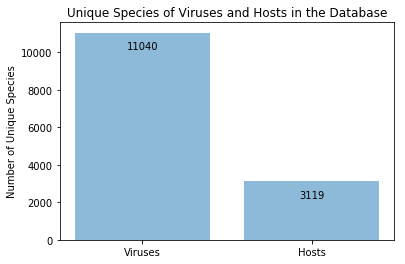

In [9]:
def makeUniqueVirusesHostsPlot(uniqueViruses, uniqueHosts):
    cats = ('Viruses', 'Hosts')
    y_pos = np.arange(len(cats))
    x_pos = (uniqueViruses, uniqueHosts)

    fig, ax = plt.subplots()

    bars = ax.bar(y_pos, x_pos, align='center', alpha = 0.5, tick_label=cats)
    ax.set_xticks(y_pos, cats)
    ax.set_ylabel('Number of Unique Species')
    ax.set_title('Unique Species of Viruses and Hosts in the Database')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height-1000, '%d' % int(height), ha='center', va='bottom')
        
makeUniqueVirusesHostsPlot(len(myEntries.keys()), hostCounter.numPresentKeys())

In [ ]:
Make a histogram showing number of hosts per virus

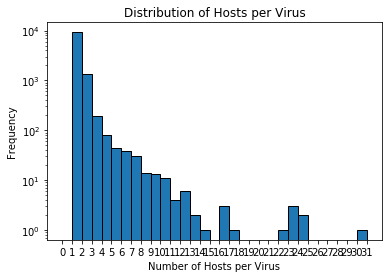

In [10]:
def hostsPerVirusPlot(myEntries):
    counts = []
    largest = 0
    for key, record in myEntries.items():
        count = len(record.hosts)
        if count > largest:
            largest = count
        counts.append( float(count) )

    countsArray = np.array(counts)
    bins = np.arange(largest)

    fig, ax = plt.subplots()

    hist = ax.hist(countsArray, bins, log=True, linewidth=1, edgecolor='black')
    ax.set_xticks(bins)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Number of Hosts per Virus')
    ax.set_title('Distribution of Hosts per Virus')
    
hostsPerVirusPlot(myEntries)

In [ ]:
Make a bar graph of the clades species belong to

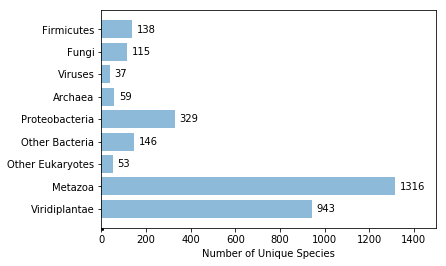

In [11]:
def hostCladesPlot(myEntries):
    countedHostIds = []
    cladeCounter = Counter()
    for virus_tax_id, record in myEntries.items():
        for host in record.hosts:
            #print(host)
            if host.tax_id not in countedHostIds:
                countedHostIds.append(host.tax_id)
                #print(host.lineage)
                splitLineage = host.lineage.split('; ')
                if len(splitLineage) < 2:
                    continue
                #print(splitLineage)
                cladeCounter.add((splitLineage[0], splitLineage[1]), 1)

    #print(cladeCounter.dict)

    prunedCladeCounter = Counter()
    for (clade1, clade2), count in cladeCounter.items():
        if count > 100:
            prunedCladeCounter.add( (clade1, clade2), count )
        else:
            prunedCladeCounter.add( (clade1, clade1), count )
    
    #print(prunedCladeCounter.dict)
    clades = []
    counts = []
    for (clade1, clade2), count in prunedCladeCounter.items():
        clade = None
        if (clade2 == 'Eukaryota'):
            clade = 'Other Eukaryotes'
        elif (clade2 == 'Bacteria'):
            clade = 'Other Bacteria'
        else:
            clade = clade2
        clades.append(clade)
        counts.append(count)

    fig, ax = plt.subplots()

    y_pos = np.arange(len(clades))
    bars = ax.barh(y_pos, counts, align='center', alpha=0.5, tick_label=clades)
    ax.set_xticks(y_pos, clades)
    ax.set_xlabel('Number of Unique Species')
    ax.set_xlim(0, 1500)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 20, bar.get_y() + bar.get_height()/2., '%d' % int(width), ha='left', va='center')
        #plt.text(bar.get_x() + bar.get_width()/2., height-1000, '%d' % int(height), ha='center', va='bottom')
        
hostCladesPlot(myEntries)